In [39]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## NMF for topic analysis

### Example

Let's look at users ratings of different movies. The ratings are from 1-5. A rating of 0 means the user hasn't watched the movie.

|       | Matrix | Alien | Serenity | Casablanca | Amelie |
| ----- | ------ | ----- | -------- | ---------- | ------ |
| **Alice** |      1 |     1 |        1 |          0 |      0 |
|   **Bob** |      3 |     3 |        3 |          0 |      0 |
| **Cindy** |      4 |     4 |        4 |          0 |      0 |
|   **Dan** |      5 |     5 |        5 |          0 |      0 |
| **Emily** |      0 |     2 |        0 |          4 |      4 |
| **Frank** |      0 |     0 |        0 |          5 |      5 |
|  **Greg** |      0 |     1 |        0 |          2 |      2 |

Note that the first three movies (Matrix, Alien, Serenity) are Sci-fi movies and the last two (Casablanca, Amelie) are Romance. We will be able to mathematically pull out these topics!

In [40]:
import pandas as pd
import numpy as np

M = np.array([[1, 1, 1, 0, 0],
              [3, 3, 3, 0, 0],
              [4, 4, 4, 0, 0],
              [5, 5, 5, 0, 0],
              [0, 2, 0, 4, 4],
              [0, 0, 0, 5, 5],
              [0, 1, 0, 2, 2]])

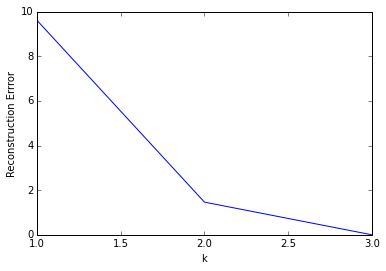

In [41]:
# Compute NMF
from sklearn.decomposition import NMF

def fit_nmf(k):
    nmf = NMF(n_components=k)
    nmf.fit(M)
    W = nmf.transform(M);
    H = nmf.components_;
    return nmf.reconstruction_err_

error = [fit_nmf(i) for i in range(1,4)]
plt.plot(range(1,4), error)
plt.xlabel('k')
plt.ylabel('Reconstruction Errror')

In [55]:
# Fit using 3 hidden concepts
nmf = NMF(n_components=3)
nmf.fit(M)
W = nmf.transform(M);
H = nmf.components_;
print 'RSS = %.4f' % nmf.reconstruction_err_

RSS = 0.0004


In [56]:
# Make interpretable
movies = ['Matrix','Alien','Serenity','Casablanca','Amelie']
users = ['Alice','Bob','Cindy','Dan','Emily','Frank','Greg']

W, H = (np.around(x,2) for x in (W,H))
W = pd.DataFrame(W,index=users)
H = pd.DataFrame(H,columns=movies)

print W 
print H

            0       1       2
Alice  0.4861  0.0000  0.0000
Bob    1.4584  0.0000  0.0000
Cindy  1.9445  0.0000  0.0000
Dan    2.4306  0.0000  0.0000
Emily  0.0000  1.8628  2.0578
Frank  0.0000  2.3285  0.0000
Greg   0.0000  0.9314  1.0289
   Matrix   Alien  Serenity  Casablanca  Amelie
0  2.0571  2.0571    2.0571      0.0000  0.0000
1  0.0000  0.0002    0.0000      2.1473  2.1473
2  0.0000  0.9718    0.0000      0.0000  0.0000


In [44]:
# Verify reconstruction
print np.around(W.dot(H),2)
print pd.DataFrame(M, index=users, columns=movies)

       Matrix  Alien  Serenity  Casablanca  Amelie
Alice    1.01   1.01      1.01        0.00    0.00
Bob      3.01   3.01      3.01        0.00    0.00
Cindy    4.00   4.00      4.00        0.00    0.00
Dan      5.01   5.01      5.01        0.00    0.00
Emily    0.00   2.00      0.00        4.00    4.00
Frank    0.00   0.00      0.00        5.01    5.01
Greg     0.00   1.00      0.00        2.00    2.00
       Matrix  Alien  Serenity  Casablanca  Amelie
Alice       1      1         1           0       0
Bob         3      3         3           0       0
Cindy       4      4         4           0       0
Dan         5      5         5           0       0
Emily       0      2         0           4       4
Frank       0      0         0           5       5
Greg        0      1         0           2       2


In [45]:
# Compare to SVD
from numpy.linalg import svd
r = 3

# Compute SVD
U, sigma, VT = svd(M)

# Make pretty
U, sigma, VT = (np.around(x,2) for x in (U,sigma,VT))
U = pd.DataFrame(U, index=users)
VT = pd.DataFrame(VT, columns=movies)

# Keep top two concepts
U = U.iloc[:,:r]
sigma = sigma[:r]
VT = VT.iloc[:r,:]

print U
print sigma
print VT

          0     1     2
Alice -0.14 -0.02 -0.01
Bob   -0.41 -0.07 -0.03
Cindy -0.55 -0.09 -0.04
Dan   -0.69 -0.12 -0.05
Emily -0.15  0.59  0.65
Frank -0.07  0.73 -0.68
Greg  -0.08  0.30  0.33
[ 12.48   9.51   1.35]
   Matrix  Alien  Serenity  Casablanca  Amelie
0   -0.56  -0.59     -0.56       -0.09   -0.09
1   -0.13   0.03     -0.13        0.70    0.70
2   -0.41   0.80     -0.41       -0.09   -0.09


## Interpreting Concepts
#### Think of NMF like 'fuzzy clustering'
- The concepts are clusters
- Each row (document, user, etc...) can belong to more than one concept

#### Top Questions:
1. What do the concepts (clusters) mean?
2. To which concept(s) does each user/document belong?

#### What is concept 0?

In [52]:
# Top 2 movies in genre 0
top_movies = H.iloc[0].order(ascending=False).index[:2]
top_movies

Index([u'Serenity', u'Alien'], dtype='object')

#### Which users align with concept 0?

In [47]:
# Top 2 users for genre 1
top_users = W.iloc[:,0].order(ascending=False).index[:2]
top_users    

Index([u'Dan', u'Cindy'], dtype='object')

#### What concepts does Emily align with?

In [48]:
W.loc['Emily']

0    0.00
1    1.86
2    2.06
Name: Emily, dtype: float64

#### What are all the movies in each concept?

In [49]:
# Movies in each concept
thresh = .2  # movie is included if at least 20% of max weight
for g in range(3):
    all_movies = H.iloc[g,:]
    included = H.columns[all_movies >= (thresh * all_movies.max())]
    print "Concept %i contains: %s" % (g, ', '.join(included))

Concept 0 contains: Matrix, Alien, Serenity
Concept 1 contains: Casablanca, Amelie
Concept 2 contains: Alien


#### Which users are associated with each concept?

In [50]:
# Users in each concept
thresh = .2  # user is included if at least 20% of max weight
for g in range(3):
    all_users = W.iloc[:,g]
    included = W.index[all_users >= (thresh * all_users.max())]
    print "Concept %i contains: %s" % (g, ', '.join(included))

Concept 0 contains: Alice, Bob, Cindy, Dan
Concept 1 contains: Emily, Frank, Greg
Concept 2 contains: Emily, Greg
